# Introduction

The purpose of this exercise is to introduce the basics of using Flopy to construct, run and visualize a MODFLOW 6 model and its outputs. It is assumed you are familiar with MODFLOW 6.

We will cover the following:
 - creating a Simulation Object
 - creating a Model Object
 - defining time and spatial discretisation
 - adding Packages
 - writting the MODFLOW files and running the model
 - post-processing some results

This exercise is based on a simple groundwater system composed of two aquifer layers, separated by a thin low-permeability layer. A river flows across the center of the system in a straight line (not very natural, I know, but it keeps things simple for the tutorial), from West to East (left to right). The river only intersects the upper aquifer layer. The upper layer also receives recharge from rainfall.

We will represent the system using a classical structured grid. 

In [1]:
# Import necessary libraries
# for the purposes of this course we are using frozen versions of flopy to avoid depedency failures.  
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Simulation
FloPy requires that we first create a "simulation" object. This simulation can have multiple models. There are a couple of things that you will generaly have to assign:
- a Simulation package
- a TDIS package
- one or more MF6 Models, which will generaly require:
    - an IMS (i.e. the solver settings) package
    - a spatial discretisation (DIS, DISV or DISU) package
    - initial condition package
    - hydraulic property package(s)
    - boundary condition pacakge(s)


A Simulation Object is instantiated with the command: *flopy.mf6.MFSimulation()*

Three inputs are usually necessary (they all have default values):
 - the simulation name
 - the path to the executable (in our case mf6.exe)
 - the path to the simulation folder

In [2]:
# you can customize the simulation name
sim_name = 'symple_ex01'

# if the MF6 executable is in your PATH, you can simply assign the string "mf6". 
# If not, you need to specify the path to the executable. 
# In the course repository folder, there is a folder named "bin" which contians all the necessary executables. 
# The MODFLOW 6 executable is named "mf6.exe":
exe_name = os.path.join('..','bin', 'mf6.exe')

# define the location of the model working directory; this is where all the MF6 files will be written
# the folder path is relative to the location in which python is running. In our case, relative to the location of the jupyter notebok file.
workspace = os.path.join('..','models','symple_ex01')

# Usually you will want to assing the Simulation Object to a variable (common practice is to name it "sim") so that it can be accessed later
sim = flopy.mf6.MFSimulation(sim_name=sim_name,
                            exe_name=exe_name,
                            version="mf6", 
                            sim_ws=workspace)

### The TDIS (time discretisation) object
Time discretisation (i.e. the TDIS package) is defined at the simulation level. Let's instantiate a Tdis object. To do so, we need to define the stress period data.

Stress period data needs to be passed to the Tdis object as a list of tuples. The list needs a tuple for each stress period. Each tuple contains the period length, the number of time steps and the time-step multiplier:
 \[(perlen, nstp, tsmult)]

We will have a single steady-state stress-period, so period length does not matter. In this case the number of time steps should be 1, and time-step multiplier does not matter.

In [3]:
# define the time units for the simulation. All model inputs must have time-units of "day"
time_units = 'days'

#perioddata[perlen, nstp, tsmult]
perioddata = [(1.0, 1, 1.0)]

# the number of periods is 1
nper = 1 

# Create the TDIS Object
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)

## The Flow Model
 Now we can create the FloPy MF6 Model Object and add the corresponding IMS package to the simulation.

In [4]:
# Instantiate the Flopy groundwater flow (gwf) model object, refercing the "sim" Simulation Object
model_name = 'symp01'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name,
                            save_flows=True, print_flows=True)

# Instantiate a Flopy `IMS` Package object
# Here you can set all the solver settings.
ims = flopy.mf6.ModflowIms(sim,
                            pname="ims",
                            complexity="SIMPLE",
                            linear_acceleration="BICGSTAB",)

# lastly we need to register the MF6 model to an IMS package in the Simulation
sim.register_ims_package(ims, [gwf.name])

### The Model Grid
So far we have created the Simulation, defined the Simulations time-discretisation and created a Model as part of that Simulation. 

Now we will start constructing the model itself. The Model will be built by adding packages to it that describe the features of the system. The first step is to define the spatial discretisation, as this is required before trying to assign any of the hydraulic property or stress packages. 

Recall that we will be using a classical structured grid. A Flopy DIS Object is created with *flopy.mf6.ModflowGwfdis()*. Note that DISV or DISU grids are created with their respective functions, which will be covered in other exercises.

To define sptial discretisation we require:
 - number of layers (3)
 - number of rows and columns
 - row and column lenght
 - elevation of the top of the model
 - elevation of the bottom of each layer

In [5]:
# set the length units. All model input values must have untis of length in "meters"
length_units = "METERS"
# number of layers
nlay = 3

# define the number of rows/columns
# our system covers a square area of 1x1.5 km. The extent in the x and y directions are 1000m and 1500m, respectively.
Lx = 1000
Ly = 1500
# we want our model grid to have cell sizes of 100 x 100 m
delr = 100 #row length
delc = 100 #column length
print(f'Cell size:{delr} x {delc}')
# we can compute the number of rows/columns:
ncol = int(Lx/delc)
nrow = int(Ly/delr)
print(f'Number of rows:{nrow}')
print(f'Number of columns:{ncol}')

# surface elevation of the systme is flat and equal to 50 m above some reference (e.g. sea-level)
top = 50
# the bottom of the upper-aquifer is at 40m; the aquitard at 35m and the lower aquifer at 0m
botm = [40, 35, 0]

# create the DIS object
dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

Cell size:100 x 100
Number of rows:15
Number of columns:10


In [6]:
# Lets check out the layer bottom elevations
dis.botm

Layer_1{constant 40}
Layer_2{constant 35}
Layer_3{constant 0}

### Packages
Now that we have the "skeleton" of the model (i.e. the grid) we can assign pacakges to define properties and stresses.

For this exercise, we will assign:
 - initial condiction (IC) package to set initial conditions
 - node property flow (NPF) package to set hydraulic properties
 - recharge (RCH) pacakge to assign recharge to the upper layer
 - river (RIV) package to define the river boundary condition
 - the output control (OC) package to determine how model outputs are recorded




#### Array data

In [7]:
# Create the initial conditions package
# you can set a single value for the entire model
strt = 50 
# or assign discrete values per layer. For example:
strt = [50, 50, 50]
# or even set the same value for each cell, by passing an array of shape (nlay, nrow, ncol). side note: we will go into dfferent ways to handle array data in a later exercise
# Lets do that, and set initial heads equal to the model top:
strt = top * np.ones((nlay, nrow, ncol))


# Now we can create the IC package
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)

In [8]:
# Next, let's create the NPF pacakge to assign values of hydraulic conductivity (K)
# Each layer has different K, so we wish to assign diferent values to each layer. 
# set the value of k for each layer
k = [5, 0.1, 10]

# here we can also set the icelltype to determine whether a layer is trated as variably saturated or not.
# let us set the top layer as variably saturated (i.e. unconfiend) and the others as saturated
icelltype = [1, 0, 0]

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k,
                              save_flows=True, 
                              save_specific_discharge=True) # so that we can plot specific discharge later

In [9]:
# Create the recharge package.
# For this simple exercise we will simply assign a single uniform value for the entire model run. 
# To do so we can use the rechage array package.
# Other exercises will demonstrate other ways to assign recharge using list-type data
recharge = 50/1000/365 # 50mm/yr in m/d

# Note that this is flopy.mf6.ModflowGwfrcha(). Different from flopy.mf6.ModflowGwfrch()
rch = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge)

#### List data

In [10]:
# Lastly, we need to assign the river boundary condition in the upper layer using the RIV package.
# The river will be assigned to cells in the upper layer, in row 7 (the middle of the model domain in this case)
# Here we will use list data. We will go into greater detail on how to handle list data in a later exercise.

riv_row = 7
stage = top - 5
rbot = botm[0]
cond = 0.1 * delr*delc/1

riv_spd = []
for col in range(ncol):
    riv_spd.append(((0, riv_row, col), stage, cond, rbot))

riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)

In [11]:
# create the output control (OC) package.
# Here we define how model outputs are recorded. 

# Save heads and budget output to binary files and 
# print heads to the model list file at the end of the stress period.

# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are recored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

## Write the Model files

In [12]:
# Write the model files by calling .write_simulation(). You can then inspect the workspace folder to see the MF6 input files written by Flopy. 
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model symp01...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 10 based on size of stress_period_data
    writing package oc...


## Run the Model

In [13]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Softwa

# Post-process model outputs

For MODFLOW6, Flopy has built-in methods to get model outputs for some packages using the *.output* attribute. There are other ways in which you can access model ouputs, however for the purposes of this course we will try and keep it as simple as possible. 

Common ouputs which you will likely wish to access may include:
 - heads at various times
 - budget components
 - specific discharge vectors
 - and mass, density and so on in transport models 

In [14]:
# You can check which output functions are available for any given package by using the output.methods() function.
# output functions available at the model level:
gwf.output.methods()

['zonebudget()', 'budget()', 'head()']

In [15]:
# for example for the RIV package (although it will be empty because we havent recorded any observations yet):
gwf.riv.output.methods()

['obs()']

## Heads
Depending on the settings in the OC package, simulated heads are recorded in the binary file (in our case named "symp01.hds"). 
We configured outputs to be recorded at all timesteps in the first stress period. 
As we only have a single steadystate stress period with 1 time step, heads are recorded only once. 

In [16]:
# the head file output can be loaded from the model object:
hds = gwf.output.head()

# head data can then be accessed using the get_data() or get_alldata() functions
# get_alldata() returns an array with all recorded times
heads = hds.get_alldata()

# get_alldata() returns an array of shape (number of records, nlay, nrow, ncol)
heads.shape

(1, 3, 15, 10)

In [17]:
# get_data() returns an array with a single recorded time. Which time to read is passed by the user as either:
# an index value, 
heads = hds.get_data(idx=0)
# a tuple of stressperiod and timestep, 
heads = hds.get_data(kstpkper=(0,0))
# or a value of time
heads = hds.get_data(totim=1)

# get_data() returns an array of shape (nlay, nrow, ncol)
heads.shape

(3, 15, 10)

### Plot heads
Flopy has built-in utilities to facilitate plotting. Use the PlotMapView() to plot model outputs.

Let us first create a plot of head in the upper layer:

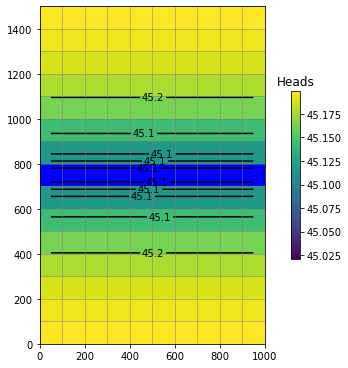

In [18]:
fig = plt.figure(figsize=(5, 5), constrained_layout=True)

# first instantiate a PlotMapView
mm = flopy.plot.PlotMapView(model=gwf)

# Plot heads
# plot the array of heads 
head_array = mm.plot_array(heads)
# add contour lines with contour_array()
contours = mm.contour_array(heads, colors='black')
# add labels to contour lines
plt.clabel(contours, fmt="%2.1f")
# add a color bar
cb = plt.colorbar(head_array, shrink=0.5, )
cb.ax.set_title('Heads')


# Plot grid 
# you can plot BC cells using the plot_bc() 
mm.plot_bc('RIV', color='blue')
# and plot the model grid if desired
mm.plot_grid(lw=0.5)

### Plot a cross-section
Plot a cross section of heads along column 5.

Text(0.5, 1.0, 'Column 5')

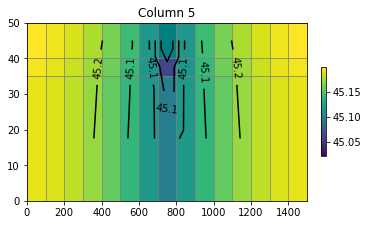

In [19]:
column = 5

# create the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

# instantiate the a PlotCrosSection object, assign it to the axis and use the "line" attribute to define the crossection. ALternatively you could use {"row":rownumber} or {"line":array of (x, y) tuples with vertices of cross-section}
mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": column})

# plot head array
head_array = mm.plot_array(heads)
# add color bar
cb = plt.colorbar(head_array, shrink=0.5, ax=ax)
# add cotour lines and labels
contours = mm.contour_array(heads, colors="black")
ax.clabel(contours, fmt="%2.1f")

# plot grid and BCs
quadmesh = mm.plot_bc("RIV")
linecollection = mm.plot_grid(lw=0.5, color="0.5")

# set the title
ax.set_title(f"Column {column}")

### Plot Specifc discharge


In [20]:
# get the specific discharge from the cell budget file
# first access the binary budget file
cbb = gwf.output.budget()

# read the specific discahrge data
spdis = cbb.get_data(text="SPDIS")[0]

# use Flopy's postprocessing functions to get specfici discharge x, y and z vectors
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

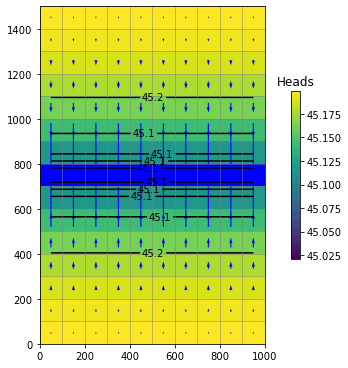

In [21]:
# Repeat the same steps as above, adding in the specific discharge quiver plot:

fig = plt.figure(figsize=(5, 5), constrained_layout=True)
# first instantiate a PlotMapView
mm = flopy.plot.PlotMapView(model=gwf)

# Plot heads
# plot the array of heads 
head_array = mm.plot_array(heads)
# add contour lines with contour_array()
contours = mm.contour_array(heads, colors='black')
# add labels to contour lines
plt.clabel(contours, fmt="%2.1f")
# add a color bar
cb = plt.colorbar(head_array, shrink=0.5, )
cb.ax.set_title('Heads')


# Plot grid 
# you can plot BC cells using the plot_bc() 
mm.plot_bc('RIV', color='blue')
# and plot the model grid if desired
mm.plot_grid(lw=0.5)

################# New Step ##########################
# add sepcific discharge vectors using plot_vector()
quiver = mm.plot_vector(qx, qy, normalize=False, color='blue')

## Read the List Budget file
If you need to check the model buget

In [22]:
mf_list = flopy.utils.Mf6ListBudget(os.path.join(workspace, f"{gwf.name}.lst"), timeunit='days')
# read as a list
incremental, cumulative = mf_list.get_budget()
# read as a Pandas DataFrame (much nicer)
incrementaldf, cumulativedf = mf_list.get_dataframes()

# inspect the incremental budget
incrementaldf.head()

,RIV_IN,RCH_IN,TOTAL_IN,RIV_OUT,RCH_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,205.479507,205.479507,205.516205,0.0,205.516205,0.036784,-0.02


In [23]:
# inspect the cumulative budget. In this case they are the same as the model has a single stress period
cumulativedf.head()

,RIV_IN,RCH_IN,TOTAL_IN,RIV_OUT,RCH_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,205.479507,205.479507,205.516205,0.0,205.516205,0.036784,-0.02
